downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to C:\Users\jcj03\scikit_learn_data


(np.float64(-0.5), np.float64(1279.5), np.float64(1279.5), np.float64(-0.5))

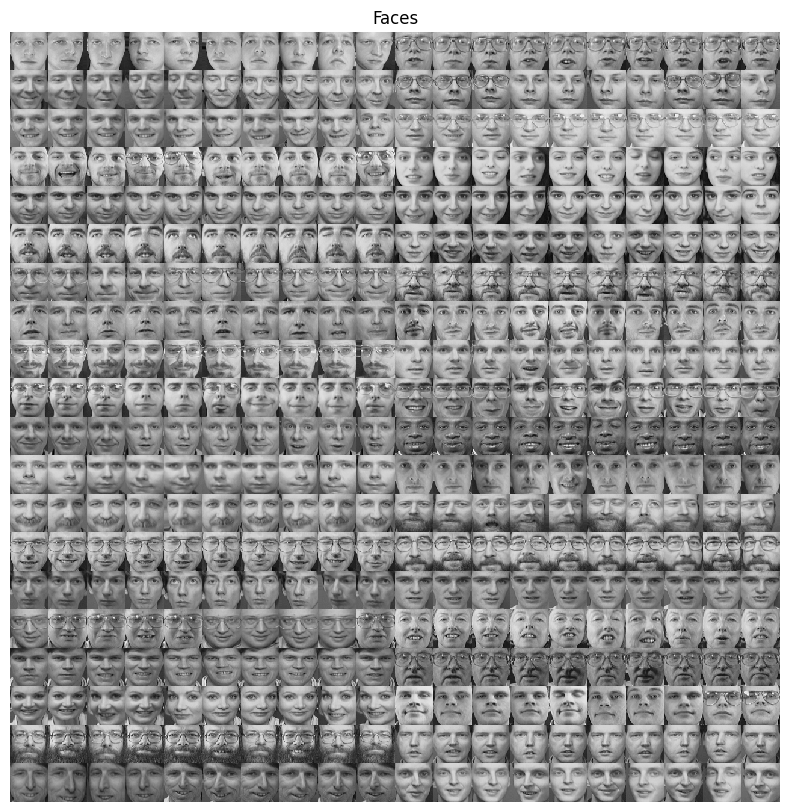

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray, gray2rgb
from skimage.util import montage
from sklearn.datasets import fetch_olivetti_faces

faces = fetch_olivetti_faces()

X_vec = np.stack([gray2rgb(iimg) for iimg in faces.data.reshape((-1,64,64))], 0)
Y_vec = faces.target.astype(np.uint8)

%matplotlib inline
fig,ax1 = plt.subplots(1,1,figsize=(10,10))
ax1.imshow(montage(X_vec[:,:,:,0]), cmap='gray', interpolation='none')
ax1.set_title('Faces')
ax1.axis('off')



In [6]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
X_train, X_test, Y_train, Y_test = train_test_split(X_vec, Y_vec, train_size = 0.7)

class PipeStep(object):
    def __init__(self, model):
        self.model = model
    def fit(self, *args):
        return self
    def transform(self, X):
        return self.model(X)

makegray_step = PipeStep(lambda img_list: [rgb2gray(img) for img in img_list])
flatten_step = PipeStep(lambda img_list: [img.ravel() for img in img_list])

simple_pipeline = Pipeline([('Make gray', makegray_step), ('Flatten', flatten_step), ('MLP', MLPClassifier(activation = 'relu', hidden_layer_sizes = (400,40), random_state = 1, max_iter = 1000))])

simple_pipeline.fit(X_train, Y_train)







Pipeline(steps=[('Make gray', <__main__.PipeStep object at 0x000001E498B4BE60>),
                ('Flatten', <__main__.PipeStep object at 0x000001E49AFCB860>),
                ('MLP',
                 MLPClassifier(hidden_layer_sizes=(400, 40), max_iter=1000,
                               random_state=1))])

In [7]:
pipe_pred_test = simple_pipeline.predict(X_test)
pipe_pred_prop = simple_pipeline.predict_proba(X_test)

from sklearn.metrics import classification_report
print(classification_report(Y_test, pipe_pred_test))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.50      0.40      0.44         5
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         4
           4       0.33      0.33      0.33         3
           5       0.14      0.50      0.22         2
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         2
           8       0.17      0.33      0.22         3
           9       0.50      0.75      0.60         4
          10       0.75      0.75      0.75         4
          11       1.00      0.25      0.40         4
          12       0.50      0.67      0.57         3
          13       0.50      0.25      0.33         4
          14       0.00      0.00      0.00         3
          15       0.00      0.00      0.00         2
          16       0.00      0.00      0.00         1
          17       1.00    

c:\Users\jcj03\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jcj03\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jcj03\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

In [9]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

explainer = lime_image.LimeImageExplainer()

segmenter = SegmentationAlgorithm('slic', n_segments=100, compactness=1, sigma=1)

explanation = explainer.explain_instance(X_test[0], simple_pipeline.predict_proba, top_labels=6, num_samples=1000, segmentation_fn=segmenter)



  0%|          | 0/1000 [00:00<?, ?it/s]

(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

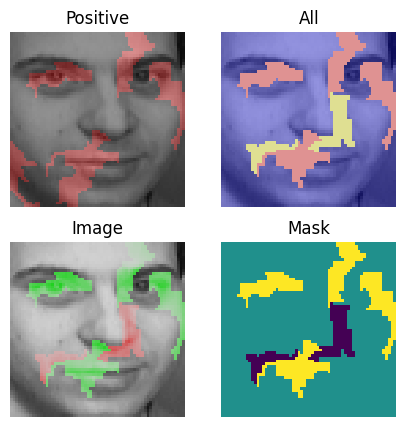

In [21]:
from skimage.color import label2rgb

label = explanation.top_labels[0]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(5,5))

temp, mask = explanation.get_image_and_mask(label, positive_only=True, num_features=8, hide_rest=False)

ax1.imshow(label2rgb(mask, temp, bg_label=0), interpolation='nearest')
ax1.set_title('Positive')
ax1.axis('off')

temp, mask = explanation.get_image_and_mask(label, positive_only=False, num_features=8, hide_rest=False)

ax2.imshow(label2rgb(4-mask, temp, bg_label=0), interpolation='nearest')
ax2.set_title('All')
ax2.axis('off')

ax3.imshow(temp, interpolation='nearest')
ax3.set_title('Image')
ax3.axis('off')

ax4.imshow(mask, interpolation='nearest')
ax4.set_title('Mask')
ax4.axis('off')
